In [1]:
import os

IMG_PATH = "_img"
CACHE_PATH = "_cache"
if not os.path.isdir(IMG_PATH): os.mkdir(IMG_PATH)
if not os.path.isdir(CACHE_PATH): os.mkdir(CACHE_PATH)

import numpy as np
import scipy.stats as st
import pandas as pd
from tqdm import tqdm
from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy import units as u

from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from astroML.density_estimation import XDGMM
from astroML.plotting.tools import draw_ellipse
from astroML.utils.decorators import pickle_results

import matplotlib.pyplot as plt
import matplotlib.patches as  mpatches
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns

sns.set_theme(context="talk", style="ticks", palette="colorblind", color_codes=True)

from MaStarChecks.constants import MASTAR_GAIA_PATH
from MaStarChecks.io import load_libraries, load_apogee
from MaStarChecks.plotting.analysis import build_comparison_table, consistency_plot, delta_plot, delta_inset_plot, move_legend
from MaStarChecks.plotting.styles import *


PROCESSED_PATH = os.path.join("../fitting/_data", "processed-libraries-v3.1.1")
CLASSIFIED_PATH = "../fitting/_data/classified-mastar-v3.1.1-cleaned-v2-gsl"

LABELS = ("MaStar",)
Y_COLUMNS = ["TEFF", "LOGG", "MET", "ALPHAM"]

def get_range(x, data=None, n=2):
    if data is None:
        xmin, xmax = x.min(), x.max()
    else:
        xmin, xmax = data[x].min(), data[x].max()
    return np.linspace(xmin, xmax, n)

units = dict(zip(Y_COLUMNS, [r"K", r"", r"", r""]))
cols = {label:f"{column}~({unit})" if unit else column for label, column, unit in zip(Y_COLUMNS, [r"$T_\mathrm{eff}$", r"$\log{g}$", r"$[\mathrm{Fe}/\mathrm{H}]$", r"$[\alpha/\mathrm{Fe}]$"], units.values())}

In [46]:
spectra, catalogues = load_libraries(labels=LABELS, spectra_types=["FLUX", "ERROR"], kind="classified-gsl",
                                    libraries_path=CLASSIFIED_PATH, use_cache=True,
                                    cache_path=CACHE_PATH, cache_label="model-cleaned-v2-gsl")

spectra_mastar = spectra["MaStar"]["FLUX"]
error_mastar = spectra["MaStar"]["ERROR"]
catalogue_mastar = catalogues["MaStar"]
del spectra, catalogues

catalogue_mastar.rename(columns=cols, inplace=True)
y_cosha = catalogue_mastar.set_index("ID").filter(items=list(cols.values()))

mastar_coords = SkyCoord(ra=catalogue_mastar.RA, dec=catalogue_mastar.DEC)
# mastar_R = mastar_coords.galactic.distance.value * np.cos(mastar_coords.galactic.l.value*np.pi/180) + 8
# mastar_z = mastar_coords.galactic.distance.value * np.sin(mastar_coords.galactic.b.value*np.pi/180)

In [3]:
spectra, catalogues = load_libraries(labels=("GSL",), libraries_path=PROCESSED_PATH, use_cache=True, cache_path=CACHE_PATH, cache_label="gsl")

spectra_gsl = spectra["GSL"]["FLUX"]
catalogue_gsl = catalogues["GSL"]
del spectra, catalogues

catalogue_gsl.rename(columns=cols, inplace=True)
y_gsl = catalogue_gsl.set_index("ID").filter(items=list(cols.values()))


In [4]:
_, catalogues = load_libraries(labels=LABELS, libraries_path=PROCESSED_PATH, use_cache=True, cache_path=CACHE_PATH, cache_label="Y19")

catalogue_y19 = catalogues["MaStar"]
del _, catalogues

catalogue_y19.rename(columns=cols, inplace=True)
y_y19 = catalogue_y19.set_index("ID").filter(items=list(cols.values()))
y_y19.dropna(how="any", inplace=True)

In [5]:
APOGEE_DISTANCES_PATH = "_data/apogee-catalogue.csv"
ASPCAP_CATALOGUE_PATH = "_data/APOGEE/allStar-l31c.2.fits"
CANNON_CATALOGUE_PATH = "_data/APOGEE/allStarCannon-l31c.2.fits"


catalogue_aspcap, catalogue_cannon = load_apogee(APOGEE_DISTANCES_PATH, ASPCAP_CATALOGUE_PATH, CANNON_CATALOGUE_PATH)
catalogue_aspcap = catalogue_aspcap.rename(columns=dict(TEFF=cols["TEFF"],LOGG=cols["LOGG"],FE_H=cols["MET"],ALPHA_M=cols["ALPHAM"]))
catalogue_cannon = catalogue_cannon.rename(columns=dict(TEFF=cols["TEFF"],LOGG=cols["LOGG"],FE_H=cols["MET"],ALPHA_M=cols["ALPHAM"]))
# catalogue_aspcap.filter(like="ERR").mean()

In [6]:
apogee_coords = SkyCoord(ra=catalogue_aspcap.RA.values*u.degree, dec=catalogue_aspcap.DEC.values*u.degree, distance=catalogue_aspcap.DIST.values*u.kpc)

# plt.scatter(mastar_R, mastar_z, lw=0, s=1, c="k")
# plt.xlim(0, 15)
# plt.ylim(-2,6)

idx, d2d, d3d = match_coordinates_sky(mastar_coords, apogee_coords)
# should be FWHM / 2 ~ 1.25"
mask = d2d.to(u.arcsec)<=1.25*u.arcsec

idx_mastar_match = y_cosha.loc[mask].index
idx_apogee_match = catalogue_aspcap.iloc[idx[mask]].index
# matches = apogee_coords[idx_match]
# print((matches.separation(mastar_coords) == d2d).all(), mask.sum())

y_cannon_match = catalogue_cannon.loc[idx_apogee_match].filter(items=cols.values())
y_aspcap_match = catalogue_aspcap.loc[idx_apogee_match].filter(items=cols.values())
y_cosha_match = y_cosha.loc[idx_mastar_match]
# plt.hist(d2d.to(u.arcsec).value[mask], bins=40)

In [7]:
GAIA_MASTAR_CATALOGUE_PATH = "_data/gaia-mastar-catalogue.csv"

if not os.path.isfile(GAIA_MASTAR_CATALOGUE_PATH):
    match_fits = fits.open(MASTAR_GAIA_PATH)

    match_columns = ["MANGAID", "SOURCE_ID"]
    match_mastar_gaia = Table(match_fits[1].data)[match_columns].to_pandas()
    match_mastar_gaia = match_mastar_gaia.rename(columns=lambda s:s.lower())
    match_mastar_gaia = match_mastar_gaia.rename(columns={"mangaid":"ID"})
    match_mastar_gaia.ID = match_mastar_gaia.ID.str.strip()
    match_mastar_gaia = match_mastar_gaia.loc[match_mastar_gaia.ID.isin(catalogue_mastar.ID)].reset_index(drop=True).sort_values("source_id")

    GAIA_PATH = "/disk-a/mejia/mastar-checks-data/stellar-libraries/Gaia"
    GAIA_CATALOGUE_PATH = os.path.join(GAIA_PATH, "catalogs")
    gaia_list = sorted([os.path.join(GAIA_CATALOGUE_PATH, filename) for filename in os.listdir(GAIA_CATALOGUE_PATH) if filename.endswith(".csv.gz")])
    gaia_ids_list = [list(map(int, os.path.basename(filename).replace(".csv.gz","").split("_")[1:])) for filename in gaia_list]
    missing_ids = np.ones_like(match_mastar_gaia.index, dtype=bool)

    filtered_gaia = []
    for i, id_range in tqdm(enumerate(gaia_ids_list), total=len(gaia_ids_list), desc="filtering gaia catalogue", ascii=True, unit="chunk"):
        ids_in_mastar = (id_range[0]<=match_mastar_gaia.source_id)&(match_mastar_gaia.source_id<=id_range[1])
        if not np.any(ids_in_mastar): continue

        gaia_chunk = pd.read_csv(gaia_list[i])
        missing_ids[match_mastar_gaia.source_id.isin(gaia_chunk.source_id)] = False
        filtered_gaia += [gaia_chunk.loc[gaia_chunk.source_id.isin(match_mastar_gaia.source_id)]]

        if not np.any(missing_ids): break

    catalogue_gaia = pd.concat(filtered_gaia, axis="index", ignore_index=True, sort=False).sort_values("source_id")
    catalogue_gaia.insert(0, "ID", match_mastar_gaia.ID.values)
    catalogue_gaia = catalogue_gaia.sort_values("ID")
    catalogue_gaia.to_csv(GAIA_MASTAR_CATALOGUE_PATH, index=False)
else:
    catalogue_gaia = pd.read_csv(GAIA_MASTAR_CATALOGUE_PATH)

catalogue_gaia = catalogue_gaia.rename(columns=dict(teff_val=cols["TEFF"], rv_template_logg=cols["LOGG"], rv_template_fe_h=cols["MET"]))
catalogue_gaia[cols["ALPHAM"]] = np.nan

y_gaia = catalogue_gaia.set_index("ID").filter(items=cols.values()).sort_index()
# y_gaia

In [49]:
spectra_mastar.values[mask][0, :]


array([1.12607157, 1.12256658, 1.1482271 , ..., 0.14576212, 0.14513677,
       0.14469098])

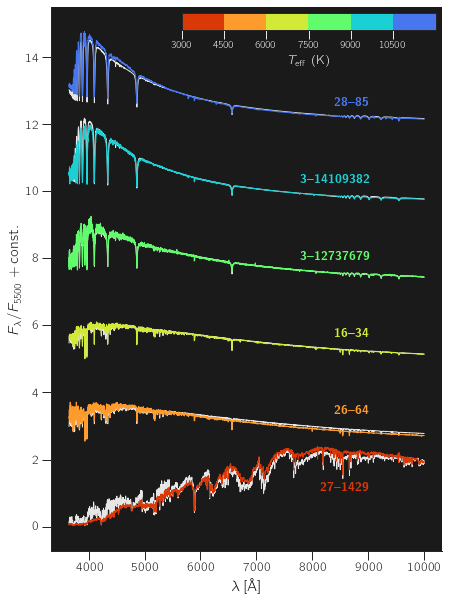

In [47]:
fig, ax = plt.subplots(figsize=(7,10))
cax = inset_axes(ax, width="65%", height="3%", loc="upper right")
cax.tick_params(labelsize="xx-small", color="0.9", labelcolor="0.9")

teff_binned = pd.cut(y_cosha[cols["TEFF"]], np.linspace(3000, 12000, 7))
logg_binned = pd.cut(y_cosha[cols["LOGG"]], 10)
fe_h_binned = pd.cut(y_cosha[cols["MET"]], 10)

teff_bins = teff_binned.cat.categories
logg_bins = logg_binned.cat.categories
fe_h_bins = fe_h_binned.cat.categories

# print(logg_bins)
# print(fe_h_bins)

SNR = 100

colors = sns.color_palette("turbo_r", teff_bins.size)
norm = plt.cm.colors.Normalize(int(teff_bins.left.min()), int(teff_bins.right.max()))
cmap = plt.cm.colors.LinearSegmentedColormap.from_list("binned_rainbow", colors, teff_bins.size)
for i, teff_bin in enumerate(teff_bins):
    mask = (teff_binned == teff_bin)&(fe_h_binned == fe_h_bins[7])&(logg_binned == logg_bins[7])
    
    norm_idx = np.argmin(np.abs(spectra_mastar.columns-5500))
    sigma_mastar = error_mastar.values[mask][0,:]#(spectra_mastar.values[mask][0,:]+2.4*i)/SNR

    ax.fill_between(
        spectra_mastar.columns,
        spectra_mastar.values[mask][0, :]+2.4*i-sigma_mastar,
        spectra_mastar.values[mask][0, :]+2.4*i+sigma_mastar,
        fc=colors[i], alpha=0.3, lw=0
    )
    ax.plot(spectra_mastar.columns, spectra_mastar.values[mask][0,:]+2.4*i, "-", color=colors[i], lw=1)
    ax.text(9000, 1+2.3*i, r"\textbf{%s}"%catalogue_mastar.loc[mask.values,'ID'].values[0].replace("-","--"), va="bottom", ha="right", color=colors[i], fontsize="x-small")
    
    # TODO: get parameter vector for each chosen star
    y_cosha_now = y_cosha.values[mask][0,:]
    idx = np.argmin(np.abs(y_cosha_now-y_gsl.values).sum(axis=1), axis=0)
    # print(y_cosha_now-y_gsl.values[idx])
    ax.plot(spectra_gsl.columns, spectra_gsl.values[idx]+2.4*i, "-", color="0.9", lw=1, zorder=-1)
    #       find the closes one in GSL parameter space
    #       plot corresponding spectra
    # last_sed = spectra_mastar.values[mask][0,:]

cb = plt.colorbar(
    plt.cm.ScalarMappable(norm,cmap),
    cax=cax,
    orientation="horizontal",
    ticks=np.round(teff_bins.left)
)
cb.set_label(cols.get("TEFF"), size="x-small", color="0.9")
sns.despine()
ax.set_facecolor("0.1")
ax.set_xlabel(r"$\lambda\,$[\AA]")
ax.set_ylabel(r"$F_\lambda/F_{5500} + \mathrm{const.}$")
fig.savefig("_img/spectra-showcase.png", bbox_inches="tight")

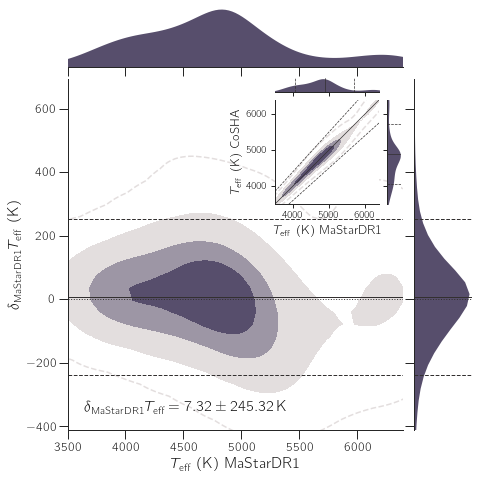

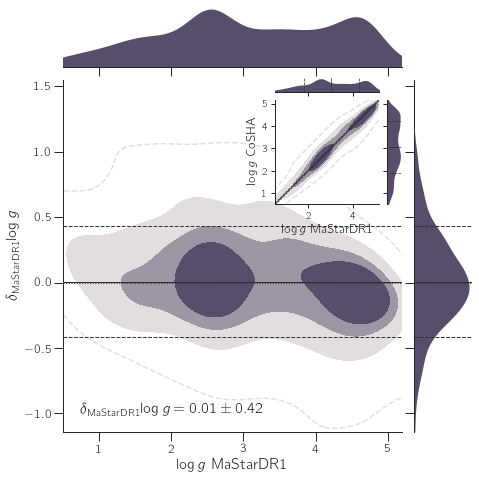

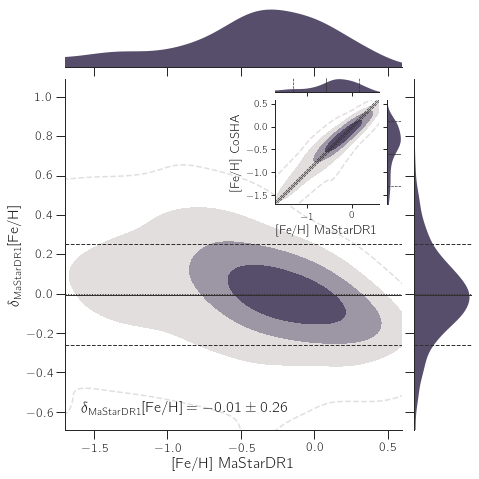

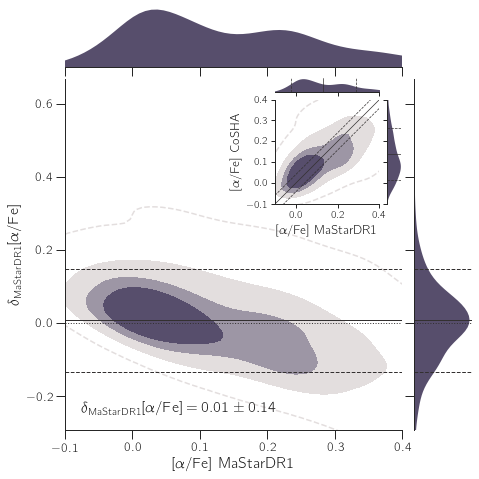

In [8]:
Y_LIMS = dict(zip(
    Y_COLUMNS,
    [np.array((3500,6400)), np.array((0.5,5.2)), np.array((-1.7,+0.6)), np.array((-0.1,+0.4))]
))

compare_with = "MaStarDR1"
comparison = build_comparison_table(y_cosha, y_y19, labela="CoSHA", labelb=compare_with, columns=list(cols.values()), delta_prefix=r"$\delta_{\mathrm{%s}}$"%compare_with)

for label, column in cols.items():
    d = delta_inset_plot(
            comparison_table=comparison,
            column=column, unit=units.get(label,""), is_logscale=label!="TEFF",
            labelx=compare_with, labely="CoSHA", delta_prefix=r"$\delta_{\mathrm{%s}}$"%compare_with,
            limx=Y_LIMS[label], guide_color="#333030"
        )
    d.fig.savefig(f"_img/{label.lower()}-residuals-inset-{compare_with.lower()}.png", bbox_inches="tight")

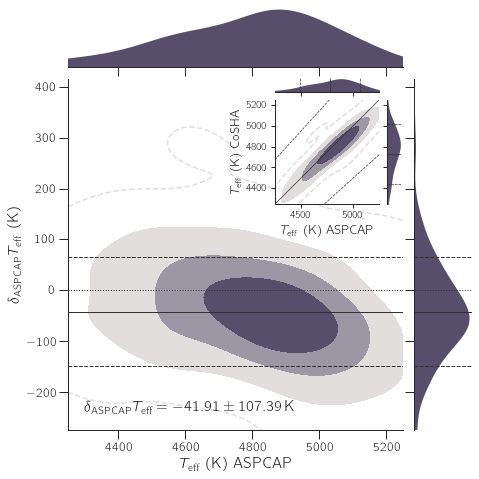

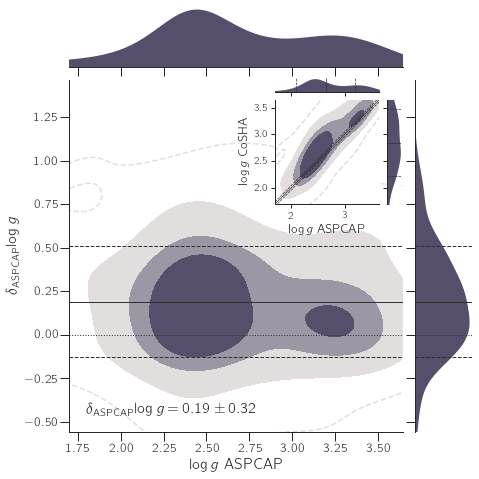

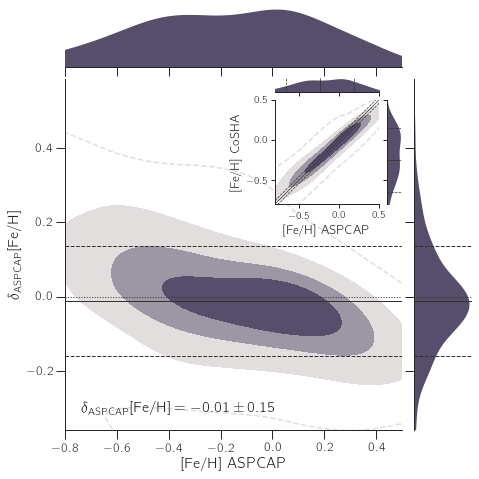

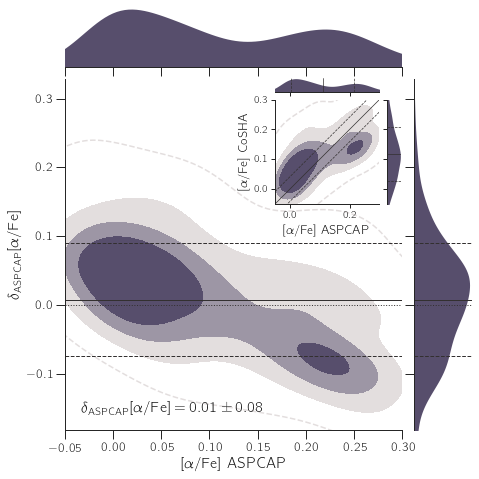

In [9]:
# Y_LIMS = dict(zip(
#     Y_COLUMNS,
#     [np.array((2300,12000)), np.array((0.0,6.0)), np.array((-4.0,+1.0)), np.array((-0.2,+1.2))]
# ))
Y_LIMS = dict(zip(
    Y_COLUMNS,
    [np.array((4250,5250)), np.array((1.7,3.65)), np.array((-0.8,+0.5)), np.array((-0.05,+0.3))]
))

compare_with = "ASPCAP"
comparison = build_comparison_table(y_cosha_match.reset_index(), y_aspcap_match.reset_index(), labela="CoSHA", labelb=compare_with, columns=list(cols.values()), delta_prefix=r"$\delta_{\mathrm{%s}}$"%compare_with)

for label, column in cols.items():    
    d = delta_inset_plot(
            comparison_table=comparison,
            column=column, unit=units.get(label,""), is_logscale=label!="TEFF",
            labelx=compare_with, labely="CoSHA", delta_prefix=r"$\delta_{\mathrm{%s}}$"%compare_with,
            limx=Y_LIMS[label], guide_color="#333030"
        )
    d.fig.savefig(f"_img/{label.lower()}-residuals-inset-{compare_with.lower()}.png", bbox_inches="tight")

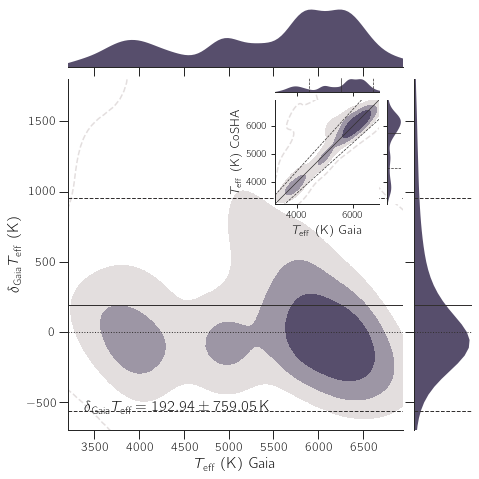

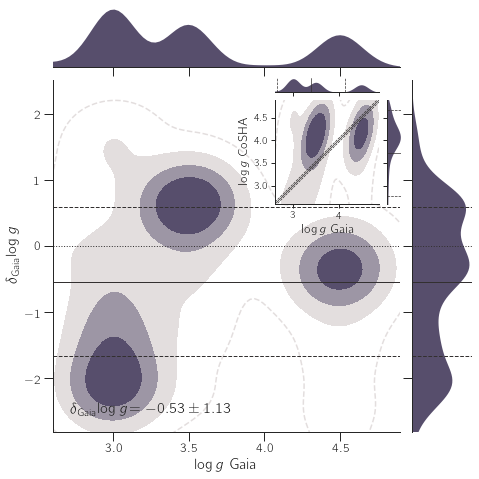

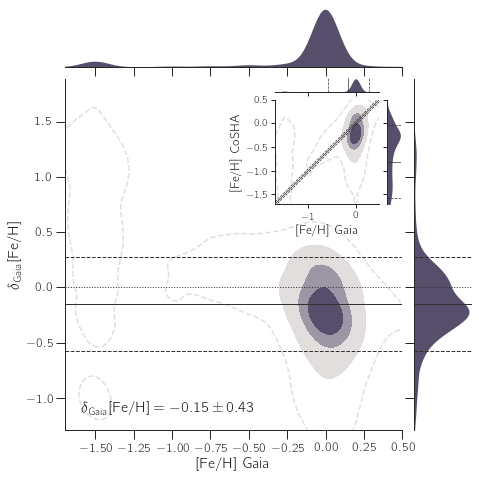

In [10]:
Y_LIMS = dict(zip(
    Y_COLUMNS,
    [np.array((3200,6950)), np.array((2.6,4.9)), np.array((-1.7,+0.5)), np.array((-0.2,+1.2))]
))
DELTA_LIMS = dict(zip(
    Y_COLUMNS,
    [np.array((-700,+1200)), None, None, None]
))

compare_with = "Gaia"
comparison = build_comparison_table(y_cosha, y_gaia, labela="CoSHA", labelb=compare_with, columns=list(cols.values()), delta_prefix=r"$\delta_{\mathrm{%s}}$"%compare_with)

for label, column in cols.items():
    if comparison[f"{column} {compare_with}"].isna().all(): continue
    d = delta_inset_plot(
            comparison_table=comparison,
            column=column, unit=units.get(label,""), is_logscale=label!="TEFF",
            labelx=compare_with, labely="CoSHA", delta_prefix=r"$\delta_{\mathrm{%s}}$"%compare_with,
            limx=Y_LIMS[label], limy=DELTA_LIMS[label], guide_color="#333030"
        )
    d.fig.savefig(f"_img/{label.lower()}-residuals-inset-{compare_with.lower()}.png", bbox_inches="tight")

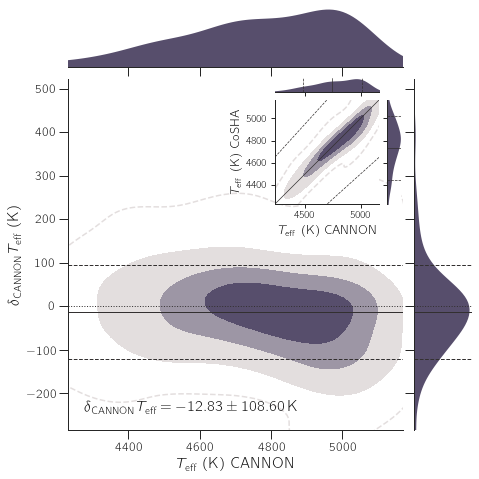

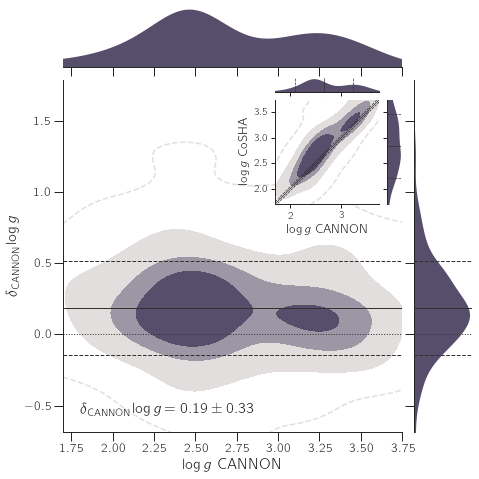

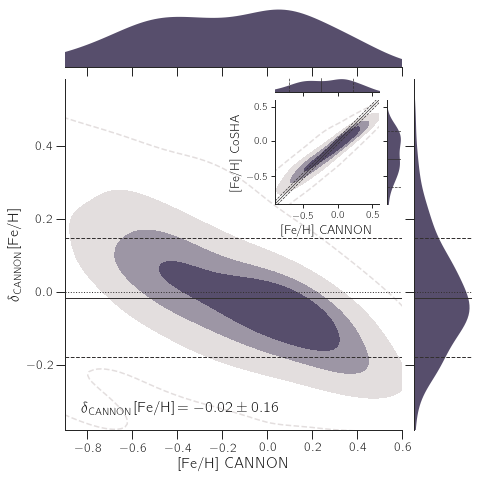

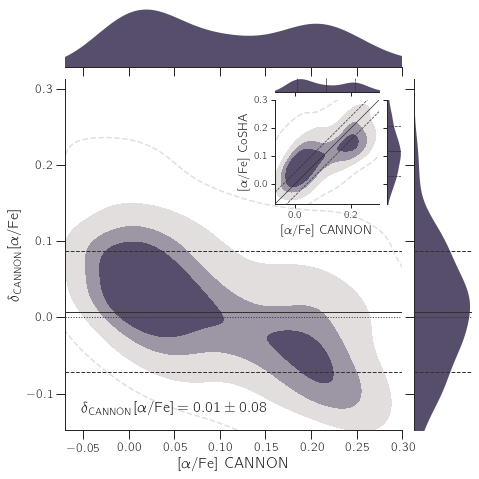

In [11]:
# Y_LIMS = dict(zip(
#     Y_COLUMNS,
#     [np.array((2300,12000)), np.array((0.0,6.0)), np.array((-4.0,+1.0)), np.array((-0.2,+1.2))]
# ))
Y_LIMS = dict(zip(
    Y_COLUMNS,
    [np.array((4230,5170)), np.array((1.7,3.75)), np.array((-0.9,+0.6)), np.array((-0.07,+0.3))]
))

compare_with = "CANNON"
comparison = build_comparison_table(y_cosha_match.reset_index(), y_cannon_match.reset_index(), labela="CoSHA", labelb=compare_with, columns=list(cols.values()), delta_prefix=r"$\delta_{\mathrm{%s}}$"%compare_with)

for label, column in cols.items():    
    d = delta_inset_plot(
            comparison_table=comparison,
            column=column, unit=units.get(label,""), is_logscale=label!="TEFF",
            labelx=compare_with, labely="CoSHA", delta_prefix=r"$\delta_{\mathrm{%s}}$"%compare_with,
            limx=Y_LIMS[label], guide_color="#333030"
        )
    d.fig.savefig(f"_img/{label.lower()}-residuals-inset-{compare_with.lower()}.png", bbox_inches="tight")

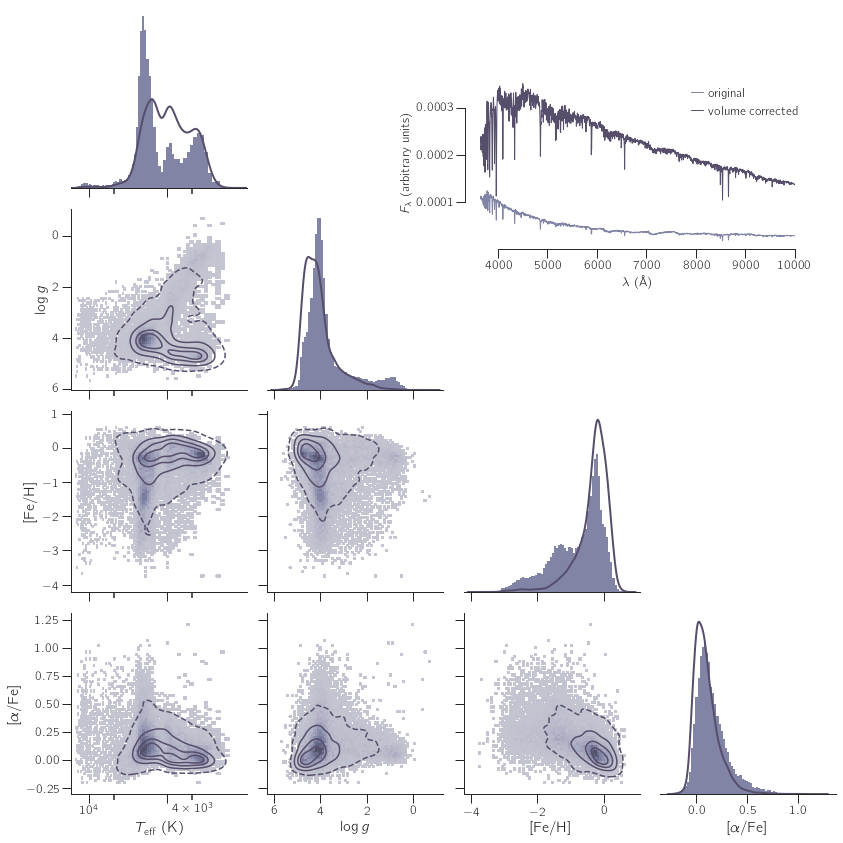

In [12]:
from itertools import combinations
from astropy.constants import L_sun


g = sns.pairplot(y_cosha, kind="hist", corner=True, height=3,
                 plot_kws={"color":MED_COLOR, "bins":70, "stat":"density"},
                 diag_kws={"lw":0, "fc":MED_COLOR, "bins":70, "stat":"density", "alpha":1.0},
                 grid_kws={"diag_sharey":False}
)
xlim = g.axes[1,0].get_xlim()
ylim = g.axes[1,0].get_ylim()
g.map_diag(sns.kdeplot, weights=catalogue_mastar.set_index("ID").VCORR, lw=2, color=MASTAR_COLOR)
g.map_lower(sns.kdeplot, weights=catalogue_mastar.set_index("ID").VCORR,
            levels=(0.05,0.25,0.50,0.75,1.00), color=MASTAR_COLOR, linewidths=1.5, linestyles=("--","-","-","-","-"))

g.axes[1,0].set_xscale("log")
g.axes[1,0].set_xlim(xlim[::-1])
g.axes[1,0].xaxis.set_major_locator(plt.MaxNLocator(1))
g.axes[1,0].xaxis.set_minor_locator(plt.MaxNLocator(3))
g.axes[1,0].set_ylim(ylim[::-1])
g.axes[1,1].set_xlim(g.axes[1,1].get_xlim()[::-1])
    
ax = g.fig.add_axes([0.55,0.7,0.4,0.2])
Lsun_per_angstroms = catalogue_mastar.FNORM.values[:,None] * (np.pi*(catalogue_mastar.DIST.values[:,None]*u.kpc).to("cm")**2) / L_sun.cgs
norm_factor = 7e1
mean_spectrum = (spectra_mastar * Lsun_per_angstroms).mean(axis="index") / norm_factor
vcor_spectrum = (spectra_mastar * Lsun_per_angstroms * catalogue_mastar.set_index("ID").VCORR.values[:,None]).sum(axis="index")
mean_spectrum.plot(color=MED_COLOR, lw=1, ax=ax, label="original")
vcor_spectrum.plot(color=MASTAR_COLOR, lw=1, ax=ax, label="volume corrected")
legend = ax.legend(loc=1)
sns.despine(ax=ax, trim=True)

ax.set_xlabel(r"$\lambda$ (\AA)", size="x-small")
ax.set_ylabel(r"$F_\lambda$ (arbitrary units)", size="x-small")

plt.savefig("_img/parameter-distributions.png", bbox_inches="tight")

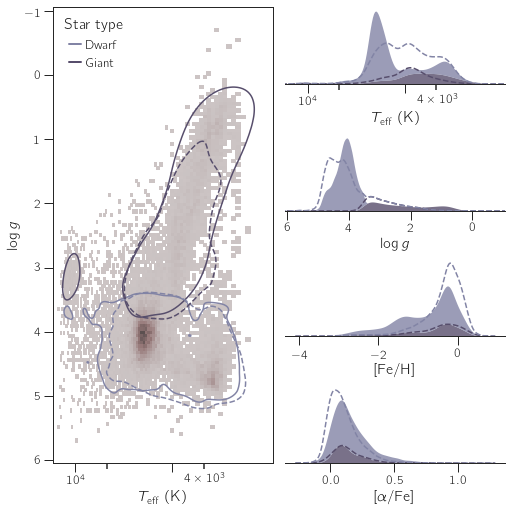

In [13]:
data = y_cosha.copy()
data["Star type"] = y_cosha[cols.get("LOGG")].apply(lambda v: "Giant" if v<3.5 else "Dwarf")

fig = plt.figure(figsize=(7,7), constrained_layout=True)

gs = GridSpec(4, 2, figure=fig)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 1])
ax4 = fig.add_subplot(gs[2, 1])
ax5 = fig.add_subplot(gs[3, 1])

sns.histplot(
    data,
    x=cols.get("TEFF"),
    y=cols.get("LOGG"),
    stat="density",
    pthresh=0.0,
    color=LIGHT_COLOR,
    ax=ax1, legend=False
)
xlim = ax1.get_xlim()
ylim = ax1.get_ylim()

colors = sns.diverging_palette(240, 20, n=2)
colors = sns.color_palette(f"blend:{MED_COLOR},{MASTAR_COLOR}", n_colors=2)
sns.kdeplot(data=data, x=cols.get("TEFF"), y=cols.get("LOGG"),
            levels=(0.05,), hue="Star type", palette=colors, linewidths=1.5, alpha=1, linestyles=("-",), ax=ax1, legend=True)
sns.kdeplot(data=data, x=cols.get("TEFF"), y=cols.get("LOGG"), weights=catalogue_mastar.set_index("ID").VCORR,
            levels=(0.05,), hue="Star type", palette=colors, linewidths=1.5, alpha=1, linestyles=("--",), ax=ax1, legend=True)

move_legend(ax1, "upper left")

ax1.set_xscale("log")
ax1.set_xlim(xlim[::-1])
ax1.xaxis.set_major_locator(plt.MaxNLocator(1))
ax1.xaxis.set_minor_locator(plt.MaxNLocator(3))
ax1.set_ylim(ylim[::-1])

sns.kdeplot(data[cols.get("TEFF")], hue=data["Star type"], multiple="stack", palette=colors, alpha=0.8, legend=False, ax=ax2)
sns.kdeplot(data[cols.get("LOGG")], hue=data["Star type"], multiple="stack", palette=colors, alpha=0.8, legend=False, ax=ax3)
sns.kdeplot(data[cols.get("MET")], hue=data["Star type"], multiple="stack", palette=colors, alpha=0.8, legend=False, ax=ax4)
sns.kdeplot(data[cols.get("ALPHAM")], hue=data["Star type"], multiple="stack", palette=colors, alpha=0.8, legend=False, ax=ax5)
sns.kdeplot(data[cols.get("TEFF")], hue=data["Star type"], multiple="stack", fill=False, ls="--", lw=1.5, weights=catalogue_mastar.set_index("ID").VCORR, palette=colors, alpha=1, legend=False, ax=ax2)
sns.kdeplot(data[cols.get("LOGG")], hue=data["Star type"], multiple="stack", fill=False, ls="--", lw=1.5, weights=catalogue_mastar.set_index("ID").VCORR, palette=colors, alpha=1, legend=False, ax=ax3)
sns.kdeplot(data[cols.get("MET")], hue=data["Star type"], multiple="stack", fill=False, ls="--", lw=1.5, weights=catalogue_mastar.set_index("ID").VCORR, palette=colors, alpha=1, legend=False, ax=ax4)
sns.kdeplot(data[cols.get("ALPHAM")], hue=data["Star type"], multiple="stack", fill=False, ls="--", lw=1.5, weights=catalogue_mastar.set_index("ID").VCORR, palette=colors, alpha=1, legend=False, ax=ax5)
plt.setp([ax2,ax3,ax4,ax5], ylabel="", yticks=[], yticklabels=[])
sns.despine(ax=ax2, left=True)
sns.despine(ax=ax3, left=True)
sns.despine(ax=ax4, left=True)
sns.despine(ax=ax5, left=True)

ax2.set_xscale("log")
ax2.set_xlim(xlim[::-1])
ax2.xaxis.set_major_locator(plt.MaxNLocator(1))
ax2.xaxis.set_minor_locator(plt.MaxNLocator(3))
ax3.set_xlim(ylim[::-1])

# plt.setp(ax1.get_legend().get_texts(), fontsize="xx-small")
# plt.setp(ax1.get_legend().get_title(), fontsize="x-small")

fig.savefig("_img/logg-teff-analysis.png", bbox_inches="tight")

@pickle_results: using precomputed results from '_cache/alpha-fe-PDF-estimator.pkl'


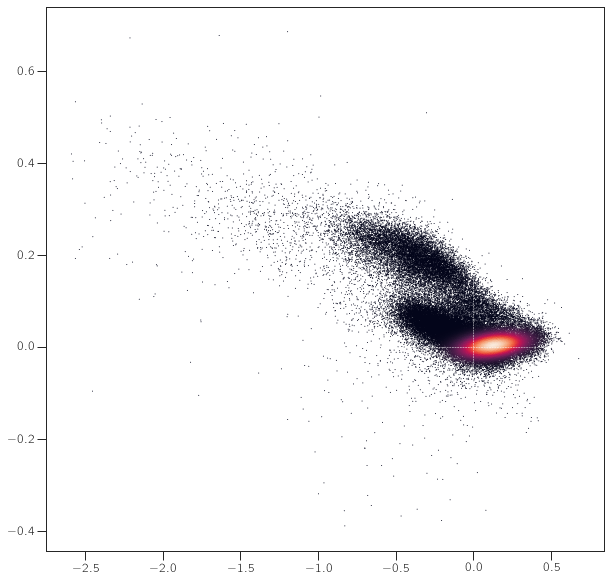

In [14]:
@pickle_results("_cache/alpha-fe-PDF-estimator.pkl")
def trainPDFestimator(data, x, y, x_err, y_err, n_components=3, max_iter=500):
    
    from MaStarChecks.plotting.analysis import density_scatter_kde, contour_masks
    
    X_alpha = data[[x, y]].values
    pdf_alpha = density_scatter_kde(X_alpha[:,0], X_alpha[:,1])
    z = pdf_alpha(X_alpha[:,0], X_alpha[:,1])

    mask_clean = contour_masks(z, levels=(0.05,)).flatten()
    
    X_alpha = X_alpha[mask_clean]
    X_alpha_err = np.zeros(X_alpha.shape + X_alpha.shape[-1:])
    diag = np.arange(X_alpha.shape[-1])
    X_alpha_err[:, diag, diag] = np.vstack([catalogue_aspcap.loc[mask_clean, x_err] ** 2, catalogue_aspcap.loc[mask_clean, y_err] ** 2]).T

    estimator = XDGMM(n_components, max_iter, verbose=True)    
    estimator.fit(X_alpha, X_alpha_err)
    
#     plt.scatter(X_alpha[:,0], X_alpha[:,1], lw=0, c="k", s=1)
#     colors = ["tab:red", "tab:orange", "tab:blue", "tab:purple"]
#     for i in range(gm.n_components):
#         draw_ellipse(gm.mu[i], gm.V[i], scales=[3], lw=0, fc=colors[i], alpha=0.2)

#     plt.xlabel(cols.get("MET"))
#     plt.ylabel(cols.get("ALPHAM"))
#     plt.xlim(-1.1, 0.6)
#     plt.ylim(-0.1, 0.35)
    
    return estimator

gm = trainPDFestimator(data=catalogue_aspcap, x=cols.get("MET"), y=cols.get("ALPHAM"), x_err="FE_H_ERR", y_err="ALPHA_M_ERR")

rv = st.multivariate_normal(gm.mu[2], gm.V[2])
z = rv.pdf(np.dstack((catalogue_aspcap[cols.get("MET")],catalogue_aspcap[cols.get("ALPHAM")])))

plt.scatter(catalogue_aspcap[cols.get("MET")], catalogue_aspcap[cols.get("ALPHAM")], c=z, lw=0, s=1)
plt.axvline(ls="--", lw=0.5, color="w")
plt.axhline(ls="--", lw=0.5, color="w")

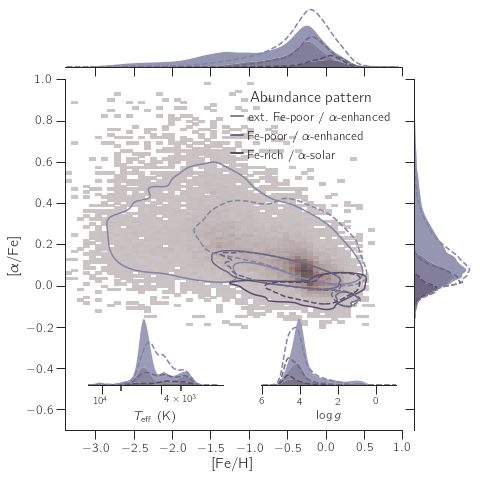

In [15]:
# build the individual pdfs found in the extreme deconvolution of the clean APOGEE data set
# assign each point in the plane to the pdf component that predicts the higher probability density
# evaluate the individual pdfs in the APOGEE data set and find out if the components correspond to the inner disk, outer disk and the thick disk
# if the individual pdfs do correspond to different regions in the MW, label them accordingly
# if not, then plot the distribution of stellar properties of each component and look for trends

alpha_pdf_labels = [r"Fe-poor~/~$\alpha$-enhanced", r"ext. Fe-poor~/~$\alpha$-enhanced", r"Fe-rich~/~$\alpha$-solar"]
alpha_rv_components = {}
alpha_rv_components[alpha_pdf_labels[0]] = st.multivariate_normal(gm.mu[0], gm.V[0])
alpha_rv_components[alpha_pdf_labels[1]] = st.multivariate_normal(gm.mu[1], gm.V[1])
alpha_rv_components[alpha_pdf_labels[2]] = st.multivariate_normal(gm.mu[2], gm.V[2])

data = y_cosha.copy()

# data["$R$"] = pd.qcut(mastar_R, q=4)
# data["$R$"] = data["$R$"].apply(lambda x: pd.Interval(left=round(x.left,1), right=round(x.right,1)))
# data["$|z|$"] = pd.qcut(np.abs(mastar_z), q=3)
# data["$|z|$"] = data["$|z|$"].apply(lambda x: pd.Interval(left=abs(round(x.left,1)), right=abs(round(x.right,1))))

for label in alpha_pdf_labels:
    data[f"PDF({label})"] = alpha_rv_components[label].logpdf(np.dstack((data[cols.get("MET")],data[cols.get("ALPHAM")])))
#     data[r"CDF$_\text{%s}$"%label] = alpha_rv_components[label].cdf(np.dstack((data[cols.get("MET")],data[cols.get("ALPHAM")])))

data["Abundance pattern"] = data.filter(like="PDF").idxmax(axis="columns").str.replace(r"PDF\(", "").str.strip(r"\)")
# data

colors = sns.color_palette(f"blend:{MED_COLOR},{MASTAR_COLOR}", n_colors=3)
pop_order = [r"ext. Fe-poor~/~$\alpha$-enhanced", r"Fe-poor~/~$\alpha$-enhanced", r"Fe-rich~/~$\alpha$-solar"]

g = sns.JointGrid(data=data, x=cols.get("MET"), y=cols.get("ALPHAM"), height=7, xlim=(-3.4,1.0), ylim=(-0.7,1))
g.plot_joint(sns.histplot, stat="density", pthresh=0.01, color=LIGHT_COLOR)
g.plot_joint(sns.kdeplot, hue=data["Abundance pattern"], hue_order=pop_order, levels=(0.05,), palette=colors, linewidths=1.5, alpha=1, linestyles=("-",), legend=True)
g.plot_joint(sns.kdeplot, hue=data["Abundance pattern"], hue_order=pop_order,
             weights=catalogue_mastar.set_index("ID").VCORR, levels=(0.05,), palette=colors, linewidths=1.5, alpha=1, linestyles=("--",), legend=True)
g.plot_marginals(sns.kdeplot, hue=data["Abundance pattern"], hue_order=pop_order, multiple="stack", palette=colors, alpha=0.85, legend=False)
g.plot_marginals(sns.kdeplot, hue=data["Abundance pattern"], hue_order=pop_order, multiple="stack", fill=False, ls="--", lw=1.5, weights=catalogue_mastar.set_index("ID").VCORR, palette=colors, alpha=1, legend=False)

axins1 = inset_axes(g.ax_joint, width="40%", height="20%", loc="lower left", bbox_to_anchor=(0.05,0.11,1,1), bbox_transform=g.ax_joint.transAxes, axes_kwargs=dict(facecolor="none"))
axins1.set_xscale("log")
axins1.set_xlim(xlim[::-1])
axins1.xaxis.set_major_locator(plt.MaxNLocator(1))
axins1.xaxis.set_minor_locator(plt.MaxNLocator(3))
axins2 = inset_axes(g.ax_joint, width="40%", height="20%", loc="lower right", bbox_to_anchor=(0,0.11,1,1), bbox_transform=g.ax_joint.transAxes, axes_kwargs=dict(facecolor="none"))
axins2.set_xlim(ylim[::-1])
axins2.xaxis.set_major_locator(plt.MaxNLocator(4))

sns.kdeplot(data[cols.get("TEFF")], hue=data["Abundance pattern"], hue_order=pop_order, multiple="stack", palette=colors, alpha=0.8, legend=False, ax=axins1)
sns.kdeplot(data[cols.get("LOGG")], hue=data["Abundance pattern"], hue_order=pop_order, multiple="stack", palette=colors, alpha=0.8, legend=False, ax=axins2)
sns.kdeplot(data[cols.get("TEFF")], hue=data["Abundance pattern"], hue_order=pop_order,
            multiple="stack", fill=False, ls="--", lw=1.5, weights=catalogue_mastar.set_index("ID").VCORR, palette=colors, alpha=1, legend=False, ax=axins1)
sns.kdeplot(data[cols.get("LOGG")], hue=data["Abundance pattern"], hue_order=pop_order,
            multiple="stack", fill=False, ls="--", lw=1.5, weights=catalogue_mastar.set_index("ID").VCORR, palette=colors, alpha=1, legend=False, ax=axins2)
plt.setp([axins1,axins2], ylabel="", yticks=[], yticklabels=[])
sns.despine(ax=axins1, left=True)
sns.despine(ax=axins2, left=True)
axins1.tick_params(axis="x", which="both", labelsize="xx-small")
axins2.tick_params(axis="x", which="both", labelsize="xx-small")
axins1.xaxis.label.set_size("x-small")
axins2.xaxis.label.set_size("x-small")

g.fig.savefig("_img/alpha-fe-analysis.png", bbox_inches="tight")

<AxesSubplot:xlabel='$T_\\mathrm{eff}$~(K)', ylabel='Density'>

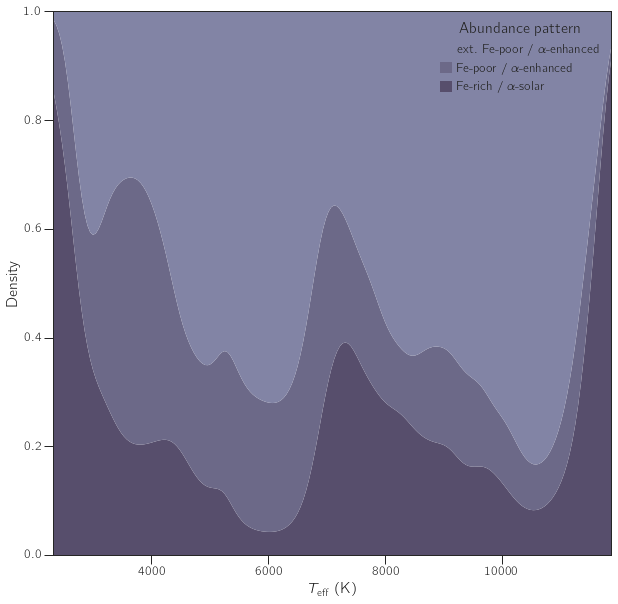

In [16]:
sns.kdeplot(data[cols.get("TEFF")], hue=data["Abundance pattern"], hue_order=pop_order,
            multiple="fill", palette=sns.color_palette(f"blend:{MED_COLOR},{MASTAR_COLOR}", n_colors=3), alpha=1, legend=True, linewidth=0)

<AxesSubplot:xlabel='$\\log{g}$', ylabel='Density'>

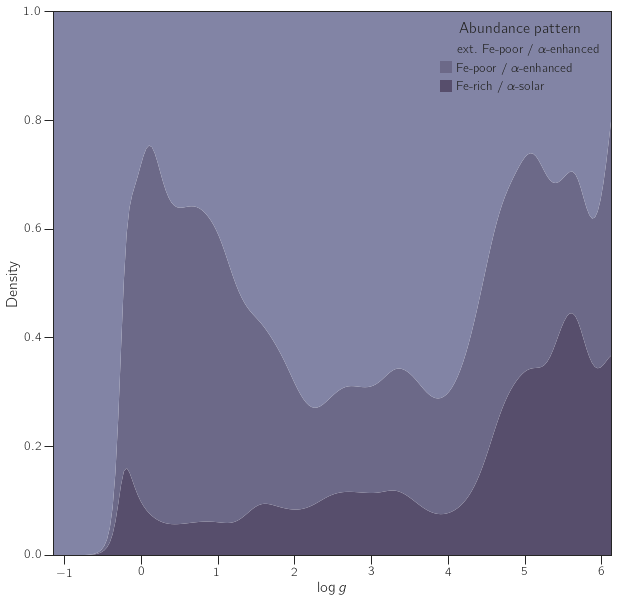

In [17]:
sns.kdeplot(data[cols.get("LOGG")], hue=data["Abundance pattern"], hue_order=pop_order,
            multiple="fill", palette=sns.color_palette(f"blend:{MED_COLOR},{MASTAR_COLOR}", n_colors=3), alpha=1, legend=True, linewidth=0)